In [1]:
import numpy as np
import random
import torch
import importlib
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import sys
sys.path.append('../')

from models.network import AutoEncoder
from data.data import ImNetImageSamples
from utils.debugger import MyDebugger
from torch.multiprocessing import Pool, Process, set_start_method

import matplotlib.pyplot as plt

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


def split(a, n):
    k, m = divmod(len(a), n)
    return [a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

## dataload
### create dataset
data_path = r'./../data/all_vox256_img/all_vox256_img_test.hdf5'

samples = ImNetImageSamples(data_path=data_path)

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
is_svr = True
epoch = 1_000
use_phase = False
phase = 2

arc = 'resnet50' # None 'resnet50' 'resnet18' 'new_loss'

if arc is None:
    testing_folder = r'./../pretrain/origin/' + ('image_encoder/' if is_svr else 'phase_2_model')
elif arc == 'new_loss':
    testing_folder = fr'./../pretrain/new_loss_1/image_encoder_resnet50' if is_svr else './../pretrain/origin/phase_2_model'
else:
    testing_folder = fr'./../pretrain/new_arch/image_encoder_{arc}' if is_svr else './../pretrain/origin/phase_2_model'

print(testing_folder)

config_path = os.path.join(testing_folder, 'config.py')
network_path = os.path.join(testing_folder, f'model_epoch{"_" + str(phase) if use_phase and not is_svr else ""}_{epoch}.pth')

## import config here
spec = importlib.util.spec_from_file_location('*', config_path)
config = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config)

./../pretrain/new_arch/image_encoder_resnet50


In [3]:
## loading index
sample_interval = 1
resolution = 64
max_batch = 20000
save_deformed = True
thershold = 0.01
with_surface_point = True

device_count = 1 # torch.cuda.device_count()
device_ratio = 1
worker_nums = int(device_count * device_ratio)
testing_cnt = 20

args = [(samples[i][0][0], resolution, max_batch, (-0.5, 0.5), thershold,
         samples.obj_paths[i], with_surface_point, i) for i in range(len(samples)) if
        i % sample_interval == 0]
random.shuffle(args)
args = args[:testing_cnt]
splited_args = split(args, worker_nums)
final_args = [(splited_args[i], network_path, config_path, i % device_count) for i in range(worker_nums)]

In [10]:
network_state_dict = torch.load(network_path)
network_state_dict, is_old_style_weights = AutoEncoder.process_state_dict(network_state_dict, type = 1)

if is_svr:
    if is_old_style_weights and config.encoder_type.upper() == '3DCNN':
        config = AutoEncoder.fix_old_weights_config(config)
    if not os.path.exists(config.auto_encoder_config_path):
        config.auto_encoder_config_path = os.path.join('./..', config.auto_encoder_config_path)
        config.auto_encoder_resume_path = os.path.join('./..', config.auto_encoder_resume_path)
    assert hasattr(config, 'auto_encoder_config_path') and os.path.exists(config.auto_encoder_config_path)
    auto_spec = importlib.util.spec_from_file_location('*', config.auto_encoder_config_path)
    auto_config = importlib.util.module_from_spec(auto_spec)
    auto_spec.loader.exec_module(auto_config)
    
    network = AutoEncoder(config=config)
    
    voxel_auto_encoder = AutoEncoder(config=auto_config)
    network_voxel_state_dict = torch.load(config.auto_encoder_resume_path)
    network_voxel_state_dict, _ = AutoEncoder.process_state_dict(network_voxel_state_dict, type = 1)
    voxel_auto_encoder.load_state_dict(network_voxel_state_dict)
    voxel_auto_encoder.to(device)
    voxel_auto_encoder.eval()
else:
    network = AutoEncoder(config=config).to(device)
network.load_state_dict(network_state_dict)
network = network.to(device)
_ = network.eval()

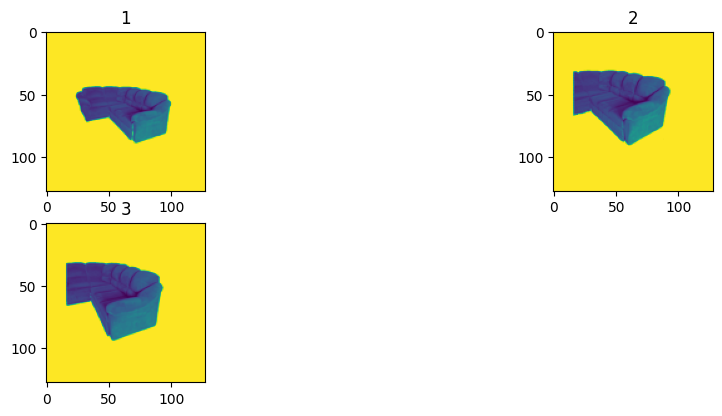

In [5]:
from PIL import Image
import cv2
from pillow_heif import register_heif_opener

register_heif_opener()

target_wh = 128, 128
is_lidar = True

indx_load = [1, 2, 3]

all_img_view = []
all_depth_view = []
all_prepared_img_view = []

for indx in indx_load:
    img_path = f'./rgbd_imgs/divan/IMG_{str(indx).zfill(4)}.HEIC'
    depth_path = img_path.replace('.HEIC', '_depth.TIF')
    mask = np.load(img_path.replace('.HEIC', '_mask.npy'))

    depth = Image.open(depth_path)
    depth = depth.transpose(Image.Transpose.ROTATE_270)
    depth_np = np.array(depth) * mask
    
    img_loaded = Image.open(img_path)
    img_loaded = img_loaded.resize(depth.size)
    img_loaded = img_loaded.convert(mode='L')
    img_loaded = Image.fromarray((np.array(img_loaded) * mask + 255 * (~mask)).astype(np.uint8), mode='L')
    img_np = np.array(img_loaded)

    target_wh = 128, 128

    img = np.ones((1, target_wh[1], target_wh[0]), dtype=np.uint8) * 255
    if img_np.shape[0] > img_np.shape[1]:
        res_wh = (
            int(img_np.shape[1] / (img_np.shape[0] // target_wh[0])), 
            target_wh[1]
        )
    else:
        res_wh = (
            target_wh[0],
            int(img_np.shape[0] / (img_np.shape[1] // target_wh[1])), 
        )

    additional_shift_wh = (
        (target_wh[0] - res_wh[0])//2,
        (target_wh[1] - res_wh[1])//2
    )

    img_loaded = np.array(img_loaded.resize(res_wh))

    img[:, additional_shift_wh[1]: res_wh[1]+additional_shift_wh[1], additional_shift_wh[0]: res_wh[0] + additional_shift_wh[0]] = img_loaded
        
    all_img_view.append(img.copy())
    all_depth_view.append(depth_np.copy())

    img = img.astype(np.float32)
    img /= 255.0
    all_prepared_img_view.append(img)

fig = plt.figure(figsize=(12, 12))
for i in range(1, len(all_img_view)+1):
    ax = fig.add_subplot(5,2,i)
    plt.imshow(all_img_view[i-1][0])
    plt.title(i)

(64,
 20000,
 (-0.5, 0.5),
 0.01,
 '04256520/db7851745fb04cf732388c13cc4a0ba3',
 True)

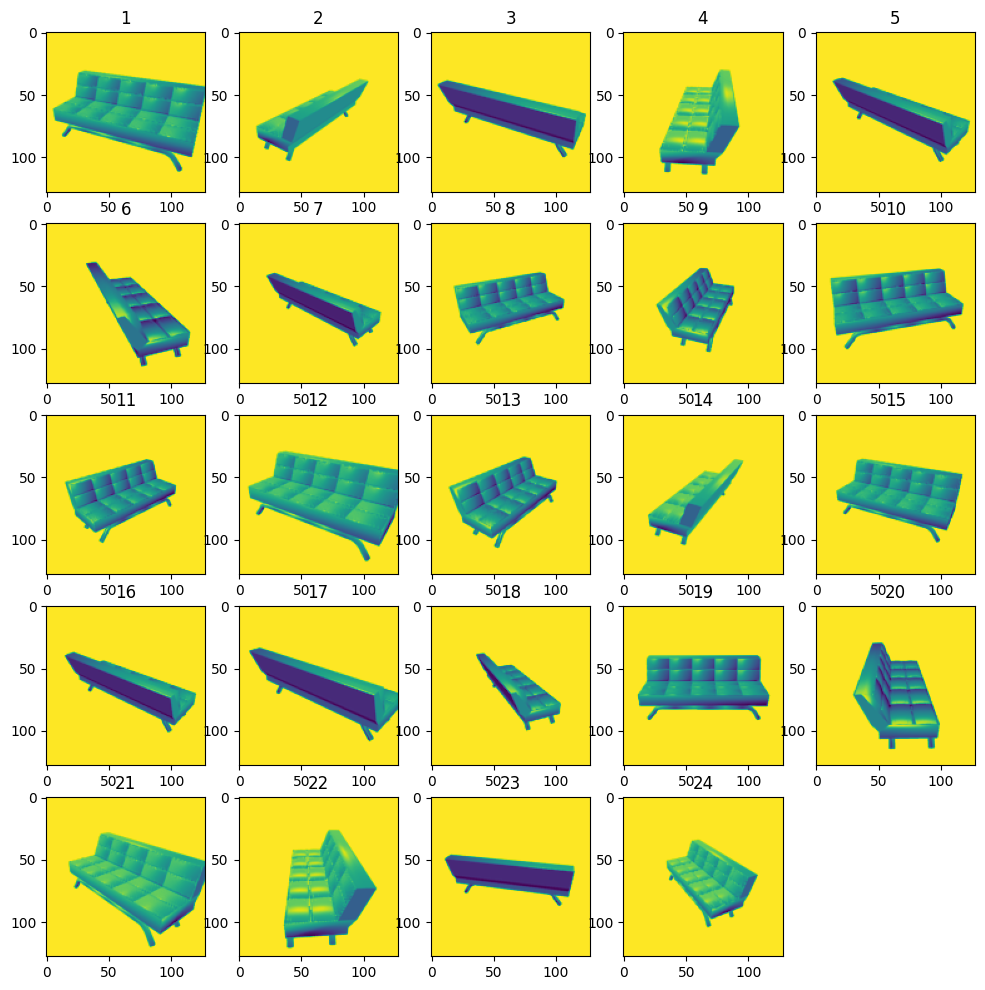

In [35]:
indx = 0
obj_indx = 6
find_obj_name = '04256520/db7851745fb04cf732388c13cc4a0ba3'
# '03001627/d16b62da42fa61f0cbce248a4e686c70'
# '04256520/db7851745fb04cf732388c13cc4a0ba3' 
# '03001627/d66b701631851e7b4b19d2c99e22ffe0'
# '04256520/db7851745fb04cf732388c13cc4a0ba3'
# '02691156/fb0f2907b977e7cb67c5e3041553656b' 
# '03001627/d16b62da42fa61f0cbce248a4e686c70'

img, resolution, max_batch, space_range, thresh, obj_path, sur_point, indx_sample = final_args[indx][0][obj_indx]

if find_obj_name is not None:
    indx_sample = samples.obj_paths.index(find_obj_name)
    img = samples.data_pixels[indx_sample, 0]
    obj_path = find_obj_name
    
gt_voxel, gt_points, gt_values = (
    samples.data_voxels[indx_sample], 
    samples.data_points[indx_sample], 
    samples.data_values[indx_sample]
)
net_path, conf_path = final_args[indx][1:-1]

all_img_view = samples.data_pixels[indx_sample].copy()

fig = plt.figure(figsize=(12, 12))
for i in range(1, len(all_img_view)+1):
    ax = fig.add_subplot(5,5,i)
    plt.imshow(np.squeeze(all_img_view[i-1]))
    plt.title(i)

resolution, max_batch, space_range, thresh, obj_path, sur_point

In [11]:
all_emb = []
for img_s in all_prepared_img_view:
    with torch.no_grad():
        img_torch = torch.from_numpy(img_s).float().to(device)
        embedding = network(img_torch.unsqueeze(0))
        all_emb.append(embedding)
all_emb = torch.stack(all_emb, dim=0)

In [12]:
!rm ./test_mean_ply/*

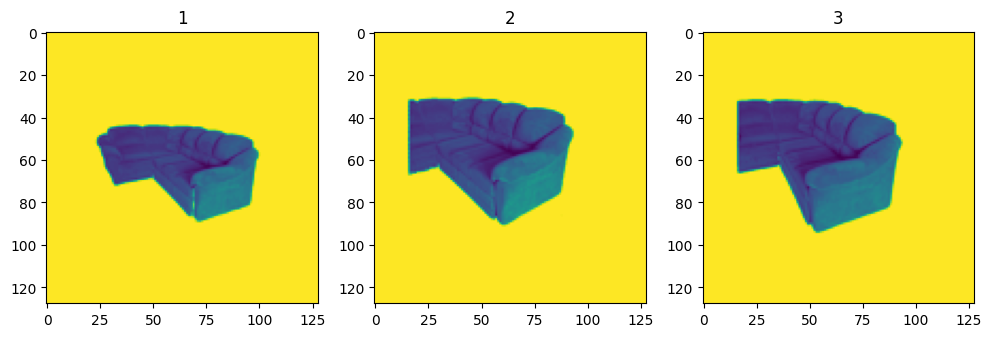

In [13]:
from utils.other_utils import write_ply_polygon

indx = [0,1,2] # [0, 14, 22] list(range(len(all_img_view)))14
save_each = True
show_each = True
thershold_1=thershold
thershold_2=0.01
space_range = (-0.5, 0.5)
max_batch = 20_000

if isinstance(indx, list):
    embeddings = all_emb[indx].clone()
    if save_each:
        for indx_s, embedding in zip(indx, embeddings):
            (vertices, polygons, vertices_deformed, polygons_deformed, 
             embedding, vertices_convex, bsp_convex_list,
             convex_predictions_sum, point_value_prediction) = network.save_bsp_deform(
                inputs=None, file_path=None, resolution=resolution, max_batch=max_batch,
                space_range=space_range, thershold_1=thershold, embedding=embedding, save_output=False, return_voxel_and_values=True
            )
            write_ply_polygon(f'test_mean_ply/mesh_deformed_{indx_s}.ply', vertices_deformed, polygons_deformed)
            write_ply_polygon(f'test_mean_ply/mesh_orginal_{indx_s}.ply', vertices, polygons)
    
    #embedding = embeddings.mean(dim=0)
    embedding, _ = embeddings.median(dim=0)
    (vertices, polygons, vertices_deformed, polygons_deformed, 
     embedding, vertices_convex, bsp_convex_list,
     convex_predictions_sum, point_value_prediction) = network.save_bsp_deform(
        inputs=None, file_path=None, resolution=resolution, max_batch=max_batch,
        space_range=space_range, thershold_1=thershold, embedding=embedding, save_output=False, return_voxel_and_values=True
    )
    write_ply_polygon(f'test_mean_ply/mesh_deformed_mean.ply', vertices_deformed, polygons_deformed)
    write_ply_polygon(f'test_mean_ply/mesh_orginal_mean.ply', vertices, polygons)
    if show_each:
        fig = plt.figure(figsize=(12, 12))
        for i in range(1, len(indx)+1):
            ax = fig.add_subplot(3,3,i)
            plt.imshow(np.squeeze(all_img_view[indx[i-1]]))
            plt.title(i)
else:
    embedding = all_emb[indx] # 19 22
    (vertices, polygons, vertices_deformed, polygons_deformed, 
     embedding, vertices_convex, bsp_convex_list,
     convex_predictions_sum, point_value_prediction) = network.save_bsp_deform(
        inputs=None, file_path=None, resolution=resolution, max_batch=max_batch,
        space_range=space_range, thershold_1=thershold, embedding=embedding, save_output=False, return_voxel_and_values=True
    )
    write_ply_polygon('test_mean_ply/mesh_deformed.ply', vertices_deformed, polygons_deformed)
    write_ply_polygon('test_mean_ply/mesh_orginal.ply', vertices, polygons)
    plt.imshow(np.squeeze(all_img_view[indx]))
    

In [119]:
thershold_1=thershold
thershold_2=0.01
space_range = (-0.5, 0.5)
max_batch = 20_000

(vertices, polygons, vertices_deformed, polygons_deformed, 
 embedding, vertices_convex, bsp_convex_list,
 convex_predictions_sum, point_value_prediction) = network.auto_encoder.save_bsp_deform(
    inputs=None, file_path=None, resolution=resolution, max_batch=max_batch,
    space_range=space_range, thershold_1=thershold, embedding=embedding, save_output=False, return_voxel_and_values=True
)

In [120]:
from utils.other_utils import write_ply_polygon

write_ply_polygon('mesh_deformed.ply', vertices_deformed, polygons_deformed)
write_ply_polygon('mesh_orginal.ply', vertices, polygons)

In [13]:
### save_bsp_deform
## build the coordinates
coordinates = network.auto_encoder.create_coordinates(resolution, space_range)

## convex weigth
convex_layer_weights = network.auto_encoder.decoder.bsp_field.convex_layer_weights.detach().cpu().numpy()

## get plane
if embedding is None:
    inputs = inputs.unsqueeze(0)
    embedding = network.auto_encoder.encoder(inputs)

NameError: name 'space_range' is not defined

In [141]:
### generate_deform_bsp

if hasattr(network.auto_encoder.config, 'flow_use_split_dim') and network.auto_encoder.config.flow_use_split_dim:
    embedding_1 = embedding[:, :network.auto_encoder.config.decoder_input_embbeding_size]
    embedding_2 = embedding[:, network.auto_encoder.config.decoder_input_embbeding_size:]
else:
    embedding_1 = embedding
    embedding_2 = embedding
embedding_1.shape, embedding_2.shape

(torch.Size([1, 128]), torch.Size([1, 128]))

In [142]:
#embedding_2_old = embedding_2.clone()

In [143]:
#embedding_2 = embedding_2 + embedding_2_old

In [144]:
#### extract_bsp_convex
plane_parms = network.auto_encoder.decoder.bsp_field.plane_encoder(embedding_2).cpu().detach().numpy()
plane_parms.shape

(1, 4, 4096)

In [145]:
convex_predictions = []
c_dim = network.auto_encoder.decoder.bsp_field.c_dim
for i in range(coordinates.size(1) // max_batch + 1):
    result = network.auto_encoder.decoder(embedding, coordinates[:, i * max_batch:(i + 1) * max_batch])
    result = result[0]

    convex_prediction = result.squeeze(0).detach().cpu().numpy()
    convex_predictions.append(convex_prediction)
if len(convex_predictions) > 1:
    convex_predictions = np.concatenate(tuple(convex_predictions), axis=0)
else:
    convex_predictions = convex_predictions[0]
convex_predictions = np.abs(convex_predictions.reshape((resolution, resolution, resolution, c_dim)))
convex_predictions_float = convex_predictions < thershold_1
convex_predictions_sum = np.sum(convex_predictions_float, axis=3)
convex_predictions_sum.shape

(64, 64, 64)

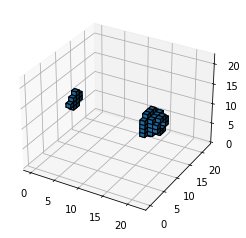

In [146]:
voxelarray = (convex_predictions_sum > 0).astype(np.int32)

ax = plt.figure().add_subplot(projection='3d')
_ = ax.voxels(voxelarray[::3, ::3, ::3], edgecolor='k')

In [147]:
bsp_convex_list = []
p_dim = network.auto_encoder.decoder.bsp_field.p_dim
cnt = 0
for i in range(c_dim):
    slice_i = convex_predictions_float[:, :, :, i]
    if np.max(slice_i) > 0:  # if one voxel is inside a convex
        if np.min(
                convex_predictions_sum - slice_i * 2) >= 0:  # if this convex is redundant, i.e. the convex is inside the shape
            convex_predictions_sum = convex_predictions_sum - slice_i
        else:
            box = []
            for j in range(p_dim):
                if convex_layer_weights[j, i] > thershold_2:
                    a = -plane_parms[0, 0, j]
                    b = -plane_parms[0, 1, j]
                    c = -plane_parms[0, 2, j]
                    d = -plane_parms[0, 3, j]
                    box.append([a, b, c, d])
            if len(box) > 0:
                bsp_convex_list.append(np.array(box, np.float32))

        cnt += 1
    print(f"{i} done! ")
print(f'with {len(bsp_convex_list)} convex and enter to function {cnt}')

#### End extract_bsp_convex

0 done! 
1 done! 
2 done! 
3 done! 
4 done! 
5 done! 
6 done! 
7 done! 
8 done! 
9 done! 
10 done! 
11 done! 
12 done! 
13 done! 
14 done! 
15 done! 
16 done! 
17 done! 
18 done! 
19 done! 
20 done! 
21 done! 
22 done! 
23 done! 
24 done! 
25 done! 
26 done! 
27 done! 
28 done! 
29 done! 
30 done! 
31 done! 
with 16 convex and enter to function 22


In [148]:
from utils.other_utils import get_mesh_watertight, write_ply_polygon

vertices, polygons, vertices_convex, polygons_convex = get_mesh_watertight(bsp_convex_list)

In [149]:
len(vertices), len(polygons), len(vertices_convex), len(polygons_convex), 

(513, 289, 16, 16)

In [150]:
from copy import deepcopy
from utils.ply_utils import triangulate_mesh_with_subdivide, read_ply_point
from evaluation.eval import calculate_cd
from evaluation.eval_utils import sample_points_polygon_vox64_njit, polygons_to_triangles

vertices_subdivided, polygons_subdivided = triangulate_mesh_with_subdivide(vertices.copy(), deepcopy(polygons))

In [151]:
vertices_result = network.auto_encoder.deform_vertices(embedding_1, max_batch, vertices)

vertices_result_subdivided = network.auto_encoder.deform_vertices(embedding_1, max_batch, vertices_subdivided)

In [152]:
(len(vertices), len(polygons), len(vertices_result),
     len(vertices_subdivided), len(polygons_subdivided), len(vertices_result_subdivided),
)

(513, 289, 513, 14430, 15392, 14430)

cd_gt_vs_pd_small=1.32 cd_gt_vs_pd=0.34 cd_pd_small_vs_pd=0.05
cd_gt_vs_pd_small_sampled=0.31 cd_gt_vs_pd_sampled=0.26 cd_pd_small_vs_pd=0.05


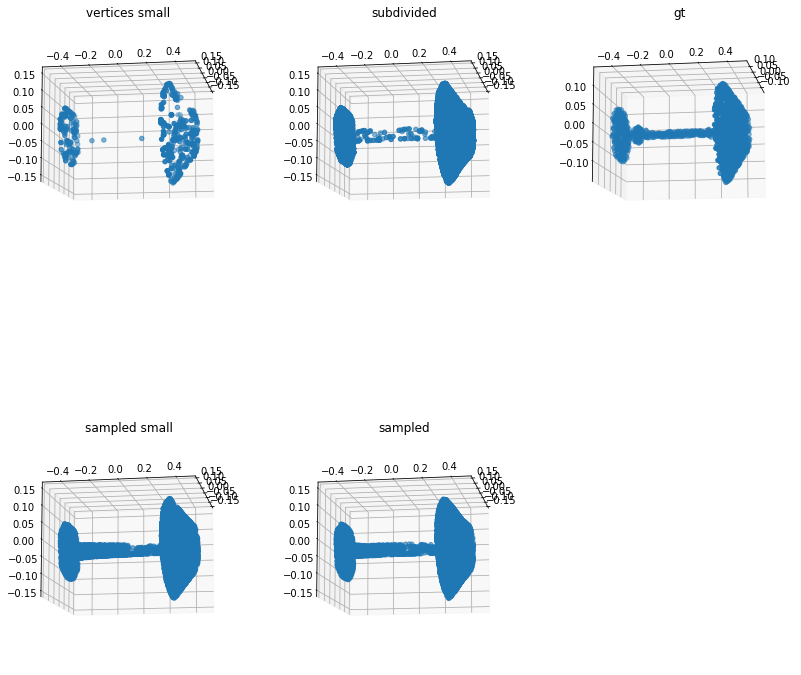

In [153]:
fig = plt.figure(figsize=(14, 14))
elev = -10
azim = 10

ax = fig.add_subplot(231, projection='3d')
ax.view_init(elev=elev, azim=azim)
_ = ax.scatter(vertices_result[:, 0], vertices_result[:, 1], vertices_result[:, 2], marker='o')
ax.set_title('vertices small')

ax = fig.add_subplot(232, projection='3d')
ax.view_init(elev=elev, azim=azim)
_ = ax.scatter(vertices_result_subdivided[:, 0], vertices_result_subdivided[:, 1], vertices_result_subdivided[:, 2], marker='o')
ax.set_title('subdivided')

gt_vertices = gt_points[gt_values[:, 0] > 1e-4]
ax = fig.add_subplot(233, projection='3d')
ax.view_init(elev=elev, azim=azim)
_ = ax.scatter(gt_vertices[:, 0], gt_vertices[:, 1], gt_vertices[:, 2], marker='o')
ax.set_title('gt')

inverted_convex_predictions = np.logical_not(convex_predictions_sum > 1e-4).astype(np.float32)
triangles = polygons_to_triangles(polygons)
sampled_points_normals = sample_points_polygon_vox64_njit(vertices_result, triangles, inverted_convex_predictions, 16384)

point_coord = np.reshape(sampled_points_normals[:,:3]+sampled_points_normals[:,3:]*1e-4, [1,-1,3])
point_coord = torch.from_numpy(point_coord).to(device)
# point_coord = np.concatenate([point_coord, np.ones([1,point_coord.shape[1],1],np.float32) ],axis=2)

_, sample_points_value, _, _ = network.auto_encoder.decoder(embedding, point_coord)
sample_points_value = sample_points_value.detach().cpu().numpy()
# Take normals only for points which are inside object
sampled_points_normals = sampled_points_normals[sample_points_value[0,:,0]>1e-4]

np.random.shuffle(sampled_points_normals)
ax = fig.add_subplot(234, projection='3d')
ax.view_init(elev=elev, azim=azim)
_ = ax.scatter(sampled_points_normals[:, 0], sampled_points_normals[:, 1], sampled_points_normals[:, 2], marker='o')
ax.set_title('sampled small')

inverted_convex_predictions = np.logical_not(convex_predictions_sum > 1e-4).astype(np.float32)
sampled_points_normals_subdivided = sample_points_polygon_vox64_njit(
    vertices_result_subdivided, polygons_subdivided, 
    inverted_convex_predictions, 16384
)

point_coord_subdivided = np.reshape(sampled_points_normals_subdivided[:,:3]+sampled_points_normals_subdivided[:,3:]*1e-4, [1,-1,3])
point_coord_subdivided = torch.from_numpy(point_coord_subdivided).to(device)
# point_coord = np.concatenate([point_coord, np.ones([1,point_coord.shape[1],1],np.float32) ],axis=2)

_, sample_points_value_subdivided, _, _ = network.auto_encoder.decoder(embedding, point_coord_subdivided)
sample_points_value_subdivided = sample_points_value_subdivided.detach().cpu().numpy()
# Take normals only for points which are inside object
sampled_points_normals_subdivided = sampled_points_normals_subdivided[sample_points_value_subdivided[0,:,0]>1e-4]

np.random.shuffle(sampled_points_normals_subdivided)
ax = fig.add_subplot(235, projection='3d')
ax.view_init(elev=elev, azim=azim)
_ = ax.scatter(sampled_points_normals_subdivided[:, 0], sampled_points_normals_subdivided[:, 1], sampled_points_normals_subdivided[:, 2], marker='o')
ax.set_title('sampled')


cd_gt_vs_pd_small = calculate_cd(gt_vertices, vertices_result)
cd_gt_vs_pd = calculate_cd(gt_vertices, vertices_result_subdivided)
cd_pd_small_vs_pd = calculate_cd(vertices_result, vertices_result_subdivided)

cd_gt_vs_pd_small_sampled = calculate_cd(gt_vertices, sampled_points_normals[:, :3])
cd_gt_vs_pd_sampled = calculate_cd(gt_vertices, sampled_points_normals_subdivided[:, :3])
cd_pd_small_vs_pd = calculate_cd(sampled_points_normals[:, :3], sampled_points_normals_subdivided[:, :3])

print('cd_gt_vs_pd_small={:.2f} cd_gt_vs_pd={:.2f} cd_pd_small_vs_pd={:.2f}'.format(
    cd_gt_vs_pd_small * 1_000, cd_gt_vs_pd * 1_000, cd_pd_small_vs_pd * 1_000))

print('cd_gt_vs_pd_small_sampled={:.2f} cd_gt_vs_pd_sampled={:.2f} cd_pd_small_vs_pd={:.2f}'.format(
    cd_gt_vs_pd_small_sampled * 1_000, cd_gt_vs_pd_sampled * 1_000, cd_pd_small_vs_pd * 1_000))

In [154]:
np.random.shuffle(vertices_result)
np.random.shuffle(vertices_result_subdivided)
np.random.shuffle(sampled_points_normals)
np.random.shuffle(sampled_points_normals_subdivided)

cd_gt_vs_pd_small = calculate_cd(gt_vertices[:4096], vertices_result[:4096])
cd_gt_vs_pd = calculate_cd(gt_vertices[:4096], vertices_result_subdivided[:4096])
cd_pd_small_vs_pd = calculate_cd(vertices_result[:4096], vertices_result_subdivided[:4096])

cd_gt_vs_pd_small_sampled = calculate_cd(gt_vertices[:4096], sampled_points_normals[:4096, :3])
cd_gt_vs_pd_sampled = calculate_cd(gt_vertices[:4096], sampled_points_normals_subdivided[:4096, :3])
cd_pd_small_vs_pd = calculate_cd(sampled_points_normals[:4096, :3], sampled_points_normals_subdivided[:4096, :3])

print('cd_gt_vs_pd_small={:.2f} cd_gt_vs_pd={:.2f} cd_pd_small_vs_pd={:.2f}'.format(
    cd_gt_vs_pd_small * 1_000, cd_gt_vs_pd * 1_000, cd_pd_small_vs_pd * 1_000))

print('cd_gt_vs_pd_small_sampled={:.2f} cd_gt_vs_pd_sampled={:.2f} cd_pd_small_vs_pd={:.2f}'.format(
    cd_gt_vs_pd_small_sampled * 1_000, cd_gt_vs_pd_sampled * 1_000, cd_pd_small_vs_pd * 1_000))

cd_gt_vs_pd_small=1.32 cd_gt_vs_pd=0.41 cd_pd_small_vs_pd=0.09
cd_gt_vs_pd_small_sampled=0.33 cd_gt_vs_pd_sampled=0.28 cd_pd_small_vs_pd=0.09


In [78]:
write_ply_polygon('mesh_deformed.ply', vertices_result, polygons)
write_ply_polygon('mesh_orginal.ply', vertices, polygons)

In [71]:
write_ply_polygon('mesh_deformed_small.ply', vertices_result, polygons)
write_ply_polygon('mesh_orginal_small.ply', vertices, polygons)

In [324]:
embedding_1.mean(), embedding_1.max(), embedding_1.min()

(tensor(0.5151, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.9999, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(0.0004, device='cuda:0', grad_fn=<MinBackward1>))

In [323]:
embedding_1_old = embedding_1.clone()

In [484]:
embedding_1_new = embedding_1_old + embedding_1

In [487]:
random_shift_t = torch.zeros((1, 128)).to(device)
random_shift_t[:, :1] = 0.01
random_shift_t[:, :20] = 1
random_shift_t[:, 100:] = -0.9
embedding_1_new = embedding_1_old + random_shift_t

In [488]:
vertices_result_new = network.auto_encoder.deform_vertices(embedding_1_new, max_batch, vertices)

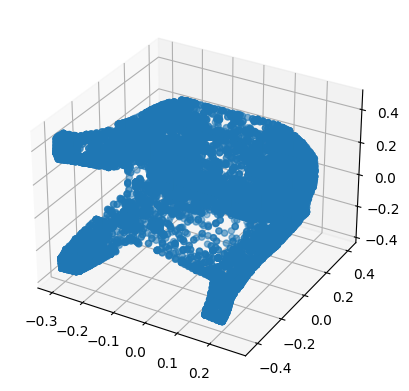

In [491]:
ax = plt.figure().add_subplot(projection='3d')
_ = ax.scatter(vertices_result_new[:, 0], vertices_result_new[:, 1], vertices_result_new[:, 2], marker='o')

In [492]:
write_ply_polygon('mesh_deformed_shifted.ply', vertices_result_new, polygons)